In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#from bokeh.models import ColumnDataSource, CategoricalColorMapper
#from bokeh.plotting import figure, show, output_file
#from bokeh.io import output_notebook
#from bokeh.layouts import column, row
#from IPython.display import HTML

from sklearn import svm, metrics, linear_model, neural_network
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
data = pd.read_csv('Absenteeism_at_work_AAA/Absenteeism_at_work.csv', sep=';')

Attribute Information:

1. Individual identification (ID)
2. Reason for absence (ICD).
Absences attested by the International Code of Diseases (ICD) stratified into 21 categories (I to XXI) as follows:

I Certain infectious and parasitic diseases  
II Neoplasms  
III Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism  
IV Endocrine, nutritional and metabolic diseases  
V Mental and behavioural disorders  
VI Diseases of the nervous system  
VII Diseases of the eye and adnexa  
VIII Diseases of the ear and mastoid process  
IX Diseases of the circulatory system  
X Diseases of the respiratory system  
XI Diseases of the digestive system  
XII Diseases of the skin and subcutaneous tissue  
XIII Diseases of the musculoskeletal system and connective tissue  
XIV Diseases of the genitourinary system  
XV Pregnancy, childbirth and the puerperium  
XVI Certain conditions originating in the perinatal period  
XVII Congenital malformations, deformations and chromosomal abnormalities  
XVIII Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified  
XIX Injury, poisoning and certain other consequences of external causes  
XX External causes of morbidity and mortality  
XXI Factors influencing health status and contact with health services.

And 7 categories without (CID) patient follow-up (22), medical consultation (23), blood donation (24), laboratory examination (25), unjustified absence (26), physiotherapy (27), dental consultation (28).
3. Month of absence
4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
5. Seasons
6. Transportation expense
7. Distance from Residence to Work (kilometers)
8. Service time
9. Age
10. Work load Average/day 
11. Hit target
12. Disciplinary failure (yes=1; no=0)
13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
14. Son (number of children)
15. Social drinker (yes=1; no=0)
16. Social smoker (yes=1; no=0)
17. Pet (number of pet)
18. Weight
19. Height
20. Body mass index
21. Absenteeism time in hours (target)

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
ID                                 740 non-null int64
Reason for absence                 740 non-null int64
Month of absence                   740 non-null int64
Day of the week                    740 non-null int64
Seasons                            740 non-null int64
Transportation expense             740 non-null int64
Distance from Residence to Work    740 non-null int64
Service time                       740 non-null int64
Age                                740 non-null int64
Work load Average/day              740 non-null float64
Hit target                         740 non-null int64
Disciplinary failure               740 non-null int64
Education                          740 non-null int64
Son                                740 non-null int64
Social drinker                     740 non-null int64
Social smoker                      740 non-null int64
Pet                          

In [4]:
new_cols = list()
for col in data.columns:
    words = col.lower().split()
    new_cols.append('_'.join(words))

data.columns = new_cols

In [5]:
column_name_mapping = {'distance_from_residence_to_work': 'work_distance', 'work_load_average/day': 'work_load',
                       'absenteeism_time_in_hours': 'absenteeism_time', 'body_mass_index': 'bmi'}
data.rename(columns=column_name_mapping, inplace=True)

data['reason_for_absence'] = data['reason_for_absence'].astype('category')

According to the original paper that used this dataset, the data was collected for every month from July 2007 to July 2010. However, the dataset doesn't contain a year attribute. But, because the data are sorted in chronological, I'll reconstruct a year attribute based on the ordering of the data.

The original paper: Martiniano, A & Pinto Ferreira, Ricardo & Sassi, Renato & Affonso, Carlos. (2012). Application of a neuro fuzzy network in prediction of absenteeism at work. Iberian Conference on Information Systems and Technologies, CISTI. 1-4.

In [6]:
year = 2007
year_list = list()
firstm_row = True
for index, row in data.iterrows():
    if row['month_of_absence'] == 1 and firstm_row:
        year += 1
        firstm_row = False
    elif row['month_of_absence'] == 2 and (not firstm_row):
        firstm_row = True
        
    year_list.append(year)
    
data['year'] = year_list

null_months = list(data[data['month_of_absence'] == 0].index)
data.loc[null_months, 'month_of_absence'] = 7

data['recorded_date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_of_absence'].astype(str))

In [7]:
data.iloc[:,:10].head(7)

,id,reason_for_absence,month_of_absence,day_of_the_week,seasons,transportation_expense,work_distance,service_time,age,work_load
0,11,26,7,3,1,289,36,13,33,239.554
1,36,0,7,3,1,118,13,18,50,239.554
2,3,23,7,4,1,179,51,18,38,239.554
3,7,7,7,5,1,279,5,14,39,239.554
4,11,23,7,5,1,289,36,13,33,239.554
5,3,23,7,6,1,179,51,18,38,239.554
6,10,22,7,6,1,361,52,3,28,239.554


In [8]:
data.iloc[:,10:].head(7)

,hit_target,disciplinary_failure,education,son,social_drinker,social_smoker,pet,weight,height,bmi,absenteeism_time,year,recorded_date
0,97,0,1,2,1,0,1,90,172,30,4,2007,2007-07-01
1,97,1,1,1,1,0,0,98,178,31,0,2007,2007-07-01
2,97,0,1,0,1,0,0,89,170,31,2,2007,2007-07-01
3,97,0,1,2,1,1,0,68,168,24,4,2007,2007-07-01
4,97,0,1,2,1,0,1,90,172,30,2,2007,2007-07-01
5,97,0,1,0,1,0,0,89,170,31,2,2007,2007-07-01
6,97,0,1,1,1,0,4,80,172,27,8,2007,2007-07-01


# Replication of the original study

This section mainly focuses on the relationship between reasons for absence and the duration of absence. The section, however, is still incomplete. The process of fuzzification for model training will be added later.

In [34]:
sns.set()

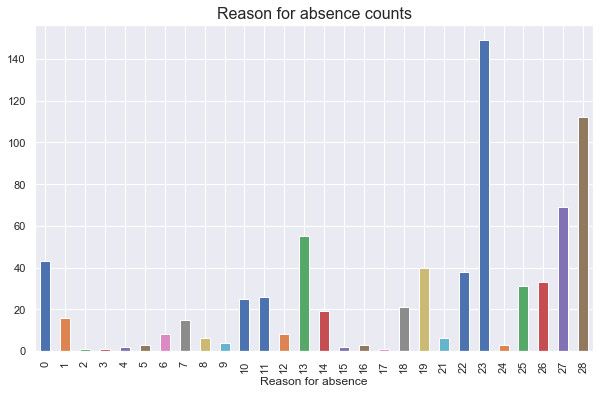

In [36]:
reason_counts = data.groupby(['reason_for_absence'])[['reason_for_absence']].count()
reason_counts.columns = ['count']

plt.figure(figsize = (10, 6))

reason_ax = reason_counts.unstack().plot.bar()
reason_ax.set_xlabel('Reason for absence')
reason_ax.set_xticklabels(reason_counts.index)
reason_ax.set_title('Reason for absence counts', fontsize=16)

plt.show()

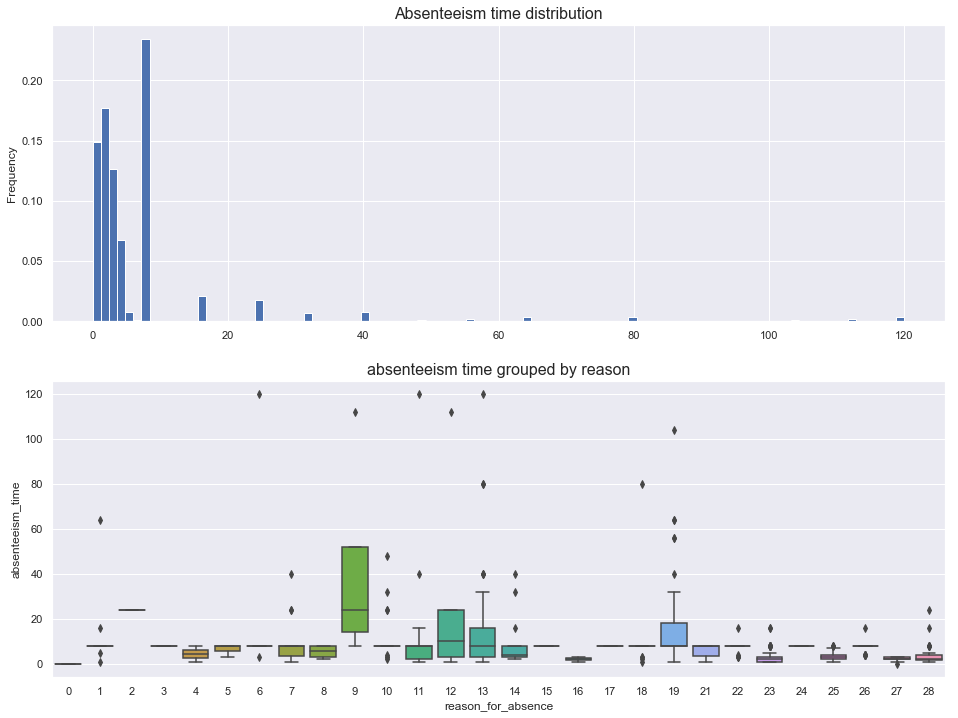

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(12)

ax1 = data['absenteeism_time'].plot.hist(bins=100, density=True, ax=axes[0])
ax1.set_title('Absenteeism time distribution', fontsize=16)

ax2 = sns.boxplot(x='reason_for_absence', y='absenteeism_time', data=data, ax=axes[1])
ax2.set_title('absenteeism time grouped by reason', fontsize=16)
plt.show()

One feature that's directly related to absenteeism time is reason for the absence even though the data is a bit sparse. In the original study, the researchers built a neuro fuzzy network to predict the value of absenteeism time for each employee using this feature alone. The authors used the one-hot-encoding to represent the input at first. One-hot-encoding is a representational vector that use 0 indicate the absence of features and 1 indicate their presence. Then the authors convert the one-hot-encodings using gaussian membership functions then feed the results into a multilayer perceptron.

In [39]:
# constructing a dataframe to further visualize
# the relationship between reason_for_absence and absenteeism_time

reason_df = data[['id', 'reason_for_absence', 'absenteeism_time']]
reason_df = reason_df.groupby(['id', 'reason_for_absence']).agg(['count', 'sum'])
reason_df = reason_df.reset_index()
reason_df.columns = ['id', 'reason_for_absence'] + ['_'.join(col) for col in reason_df.columns[2:]]
reason_df['reason_for_absence'] = pd.to_numeric(reason_df['reason_for_absence'])
reason_df.head()

,id,reason_for_absence,absenteeism_time_count,absenteeism_time_sum
0,1,0,1,0
1,1,1,1,8
2,1,7,1,3
3,1,11,1,4
4,1,13,3,25


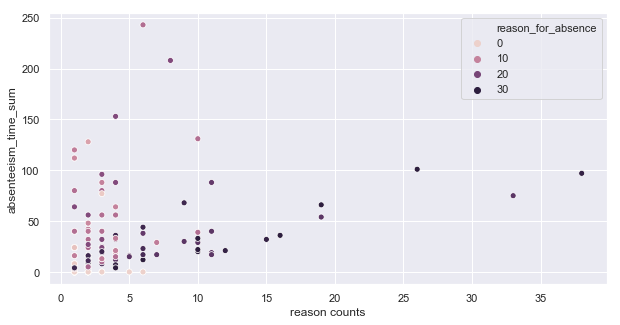

In [40]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(x='absenteeism_time_count', y='absenteeism_time_sum', hue='reason_for_absence', data=reason_df)
plt.xlabel('reason counts')
plt.show()

In [41]:
# creating dummy variables to represent one-hot-encoding input

reason_v = data[['id', 'reason_for_absence', 'absenteeism_time', 'recorded_date']]
reason_v = pd.get_dummies(reason_v, columns=['reason_for_absence'])

In [43]:
reason_v.head()

,id,absenteeism_time,recorded_date,reason_for_absence_0,reason_for_absence_1,reason_for_absence_2,reason_for_absence_3,reason_for_absence_4,reason_for_absence_5,reason_for_absence_6,...,reason_for_absence_18,reason_for_absence_19,reason_for_absence_21,reason_for_absence_22,reason_for_absence_23,reason_for_absence_24,reason_for_absence_25,reason_for_absence_26,reason_for_absence_27,reason_for_absence_28
0,11,4,2007-07-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,36,0,2007-07-01,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2,2007-07-01,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,7,4,2007-07-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,2,2007-07-01,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [44]:
train_set, test_set = reason_v[reason_v['recorded_date'] < '2010-04-01'], reason_v[reason_v['recorded_date'] >= '2010-04-01']
train_dates = reason_v.loc[reason_v['recorded_date'] < '2010-04-01', 'recorded_date']
test_dates = reason_v.loc[reason_v['recorded_date'] >= '2010-04-01', 'recorded_date']
X_train, X_test = train_set.iloc[:, 3:], test_set.iloc[:, 3:]
y_train, y_test = train_set['absenteeism_time'], test_set['absenteeism_time']

In [45]:
print(X_train.shape, X_test.shape)

(654, 28) (86, 28)


## Artificial neural network

In [46]:
hidden_sizes = [(i, j+2) for i in np.arange(5, 16) for j in range(2)]
param_grid = dict(hidden_layer_sizes=hidden_sizes)

# replicating the parameter setting from the paper
ann = neural_network.MLPRegressor(learning_rate_init=0.1, max_iter=65, momentum=0.7, random_state=123)

ann_gs = GridSearchCV(ann, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=4)

ann_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=65, momentum=0.7,
       nesterovs_momentum=True, power_t=0.5, random_state=123,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(5, 2), (5, 3), (6, 2), (6, 3), (7, 2), (7, 3), (8, 2), (8, 3), (9, 2), (9, 3), (10, 2), (10, 3), (11, 2), (11, 3), (12, 2), (12, 3), (13, 2), (13, 3), (14, 2), (14, 3), (15, 2), (15, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [47]:
print(ann_gs.best_params_)
print(ann_gs.best_score_)
y_pred = ann_gs.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_pred))

{'hidden_layer_sizes': (8, 2)}
-4.864655726258684
6.376389651413574


## ElasticNet (Linear regression with regularization)

In [48]:
param_grid = dict(l1_ratio = np.linspace(0, 1, num=11), alpha = np.arange(1,10))
en = linear_model.ElasticNet(max_iter=100, random_state=123)
en_gs = GridSearchCV(en, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=4)

en_gs.fit(X_train, y_train)

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordin

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordin

GridSearchCV(cv=4, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=100, normalize=False, positive=False, precompute=False,
      random_state=123, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'alpha': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [49]:
print(en_gs.best_params_)
y_pred = en_gs.predict(X_test)
print(metrics.mean_absolute_error(y_test, y_pred))

{'alpha': 1, 'l1_ratio': 0.0}
6.820328900776496


(To be edited) We obtained a neural network model that has mean absolute error only 0.029. But we can also predict absenteeism time with the mean absolute error as low as 0.417 even with a simple regularized linear regression model. This result shows a direct link between the reason for absence and the duration of absence. To gain more actionable insights, we probably want to explore other variables and find their relationships with each reason for absence since it could help us determine the cause of absence in the first place and eventually assist in the policy-making process to reduce absenteeism.

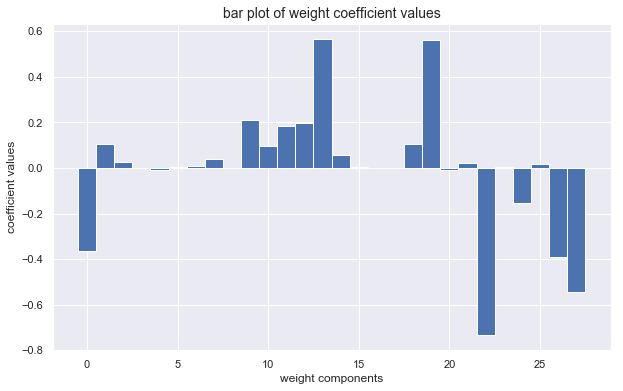

In [50]:
fig = plt.figure(figsize=(10, 6))

inds = np.arange(en_gs.best_estimator_.coef_.shape[0])
vals = en_gs.best_estimator_.coef_

plt.bar(inds, vals, width=1, align='center')
plt.xlabel('weight components')
plt.ylabel('coefficient values')
plt.title('bar plot of weight coefficient values', fontsize=14)
plt.show()

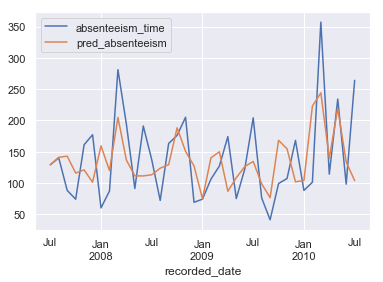

In [53]:
preds = en_gs.predict(pd.concat([X_train, X_test]))
reason_v['pred_absenteeism'] = preds 
reason_v.groupby('recorded_date')[['absenteeism_time', 'pred_absenteeism']].sum().plot.line()
plt.show()

# Exploratory data analysis

This dataset might seem to contain an ample sample size. However, a lot of data records come from the same person, so they're not entirely independent. I'll try to take this characteristic into account while performing data analysis.

In [56]:
print('total number of distinct employees in the dataset = {}'.format(data['id'].nunique()))

total number of distinct employees in the dataset = 36


## Effects of drinking and smoking

It's well-studied that drinking and smoking can cause several diseases. As a result, it can result in absence of employees. Even though the policy to restrain employees from drinking and smoking might be merely impossible, we can implement a policy that can indirectly reduce their effects and study their effects to take their effects into account when we explore other variables.

In [66]:
print(data['social_drinker'].value_counts())
print(data['social_smoker'].value_counts())

1    420
0    320
Name: social_drinker, dtype: int64
0    686
1     54
Name: social_smoker, dtype: int64


In [17]:
density_function = lambda x: x/float(x.sum())

In [58]:
def merge_drink_smoke(row):
    if row['social_drinker'] == row['social_smoker'] == 0:
        return 'non-smoker-drinker'
    elif row['social_drinker'] == 1 and row['social_smoker'] == 0:
        return 'drinker'
    elif row['social_drinker'] == 0 and row['social_smoker'] == 1:
        return 'smoker'
    elif row['social_drinker'] == row['social_smoker'] == 1:
        return 'smoker-drinker'
    
data['drink_smoke'] = data.apply(merge_drink_smoke, axis=1)

I merged 'social_drinker' and 'social_smoker' features together to see if their interaction would result in a different effect.

Then I want to check if anyone change their 'drink_smoke' category over during the time of data collection.

In [64]:
ds_dist_counts = data.groupby(['id']).agg({'drink_smoke': pd.Series.nunique})
ds_dist_counts[ds_dist_counts['drink_smoke'] > 1]

,drink_smoke
id,
29,2


In [82]:
data.loc[data['id'] == 29, ['reason_for_absence', 'age', 'recorded_date', 'drink_smoke', 'absenteeism_time']]

,reason_for_absence,age,recorded_date,drink_smoke,absenteeism_time
51,0,28,2007-09-01,non-smoker-drinker,0
592,28,41,2010-02-01,drinker,2
675,19,41,2010-05-01,drinker,3
681,14,41,2010-05-01,drinker,8
683,22,41,2010-05-01,drinker,8


I found that the employee 29 has 2 drink_smoke categories, so I checked the subject's data in the dataset to see when the subject changed his/her drink_smoke status. However, from a simple inspection, we can see the discrepancy in the age attribute. His/her age when the subject did neither drink nor smoke is entirely different from when the subject becomes a social drinker. I speculate that there was a misfiling of id during the data collection. Therefore, I'll treat the record with age 28 as a different person and assign a new id to him/her.

In [83]:
data.loc[51, 'id'] = 37

Now we can be certain that each person belongs to only 1 drink_smoke category, and there're no transitions in this category during the data collection period.

In [90]:
data.groupby('id').agg({'drink_smoke': 'first'})['drink_smoke'].value_counts()

drinker               15
non-smoker-drinker    15
smoker-drinker         4
smoker                 3
Name: drink_smoke, dtype: int64

We probably rather see the effect of "drink_smoke" feature on the population level than the magnitude of the effect on the individual level, so I'll count each reason for absence only once for each employee.

In [106]:
grouped_df = data.groupby(['id', 'reason_for_absence']).agg({'drink_smoke': ['first', 'count']}).reset_index()
grouped_df.columns = ['id', 'reason_for_absence', 'drink_smoke', 'count']
grouped_ds = grouped_df.groupby(['drink_smoke', 'reason_for_absence'])['reason_for_absence'].count()

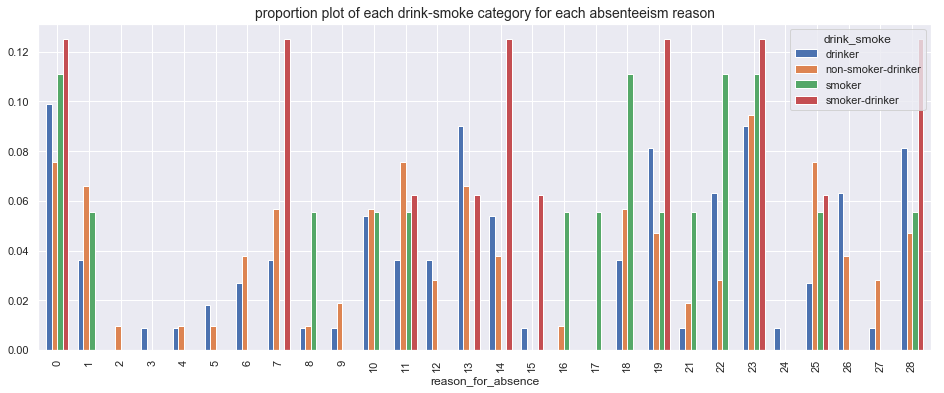

In [116]:
ax = grouped_ds.unstack('drink_smoke').fillna(value=0).apply(density_function).plot.bar(width=0.7)
fig = ax.figure
fig.set_figwidth(16)
fig.set_figheight(6)
plt.title('proportion plot of each drink-smoke category for each absenteeism reason', fontsize=14)
plt.show()

This plot shows, given the "drink_smoke" category, the proportion (probability) of people absent due to a certain reason. For example, ~11% of social smokers are absent because of reason 18, 22, and 23 (Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified, patient follow-up, and medical consultation). This visualization allows us to compare the proportion of each group of people against the others for a certain reason while not affected by the number of people belong to each group.

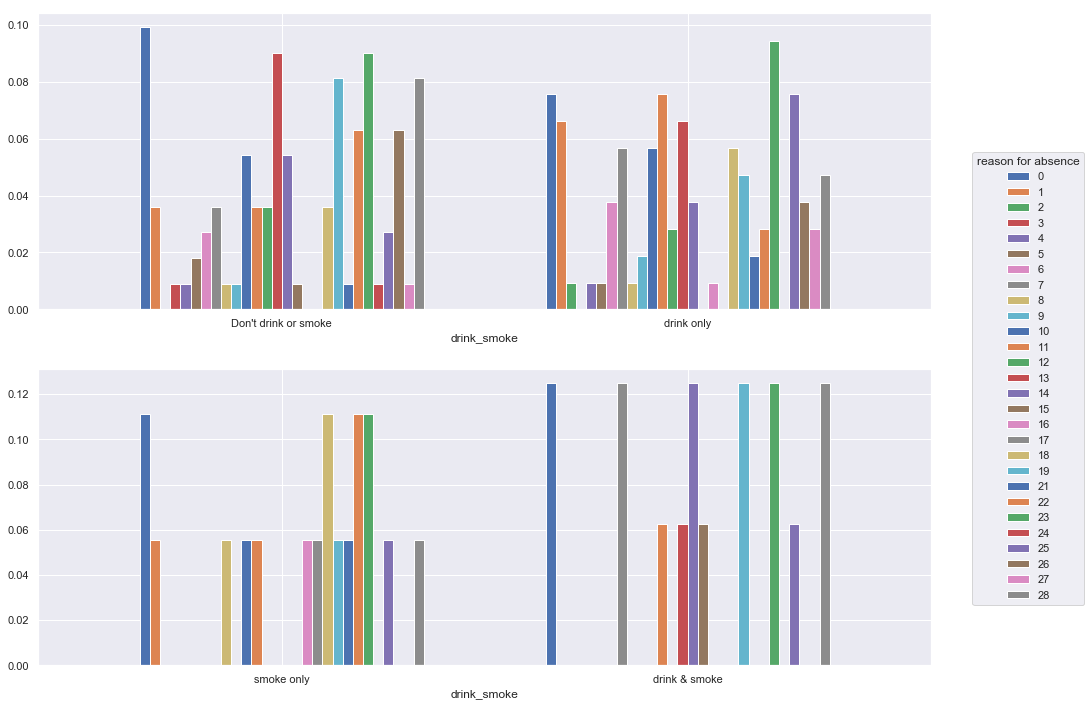

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(12)

ax = grouped_ds.unstack('reason_for_absence').fillna(0).apply(density_function, axis=1)[:2].plot.bar(width=0.7, ax=axes[0])
ax.set_xticklabels(["Don't drink or smoke", 'drink only'], rotation=0)
ax.legend_.remove()

ax = grouped_ds.unstack('reason_for_absence').fillna(0).apply(density_function, axis=1)[2:].plot.bar(width=0.7, ax=axes[1])
ax.set_xticklabels(['smoke only', 'drink & smoke'], rotation=0)
ax.legend(title='reason for absence', bbox_to_anchor=(1.04,1.75), loc="upper left")

plt.show()

Now I changed the perspective by grouping the stacks of proportion into each "drink_smoke" category, so it's easier to see which reason for absence is common among each group.

### Visualizing the magnitude of the effect (not grouped by employee id)

If we want to see the actual size of effect of "drink_smoke" category on each reason for absence, we can just use the original dataframe to visualize. But we should keep in mind that effects from employees that have many records can dominate the effects from other employees.

In [72]:
rds_group = data.groupby(['reason_for_absence', 'drink_smoke'])['id'].count()
rds_ratio_group = rds_group.groupby('drink_smoke').apply(density_function)

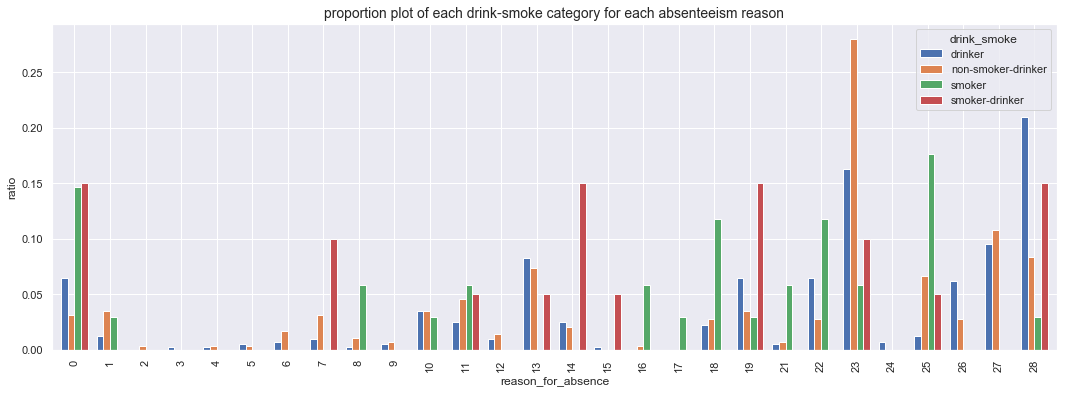

In [136]:
ax = rds_ratio_group.unstack('drink_smoke').fillna(0).plot.bar(width=0.75)
fig = ax.figure
fig.set_figwidth(18)
fig.set_figheight(6)
ax.set_ylabel('ratio')
plt.title('proportion plot of each drink-smoke category for each absenteeism reason', fontsize=14)
plt.show()

This plot shows, given the "drink_smoke" category, the proportion (probability) of absences due to a certain reason. For example, a big proportion of absence from the non-smoker-drinker category (~28%) are because of reason 23 (medical consultation).

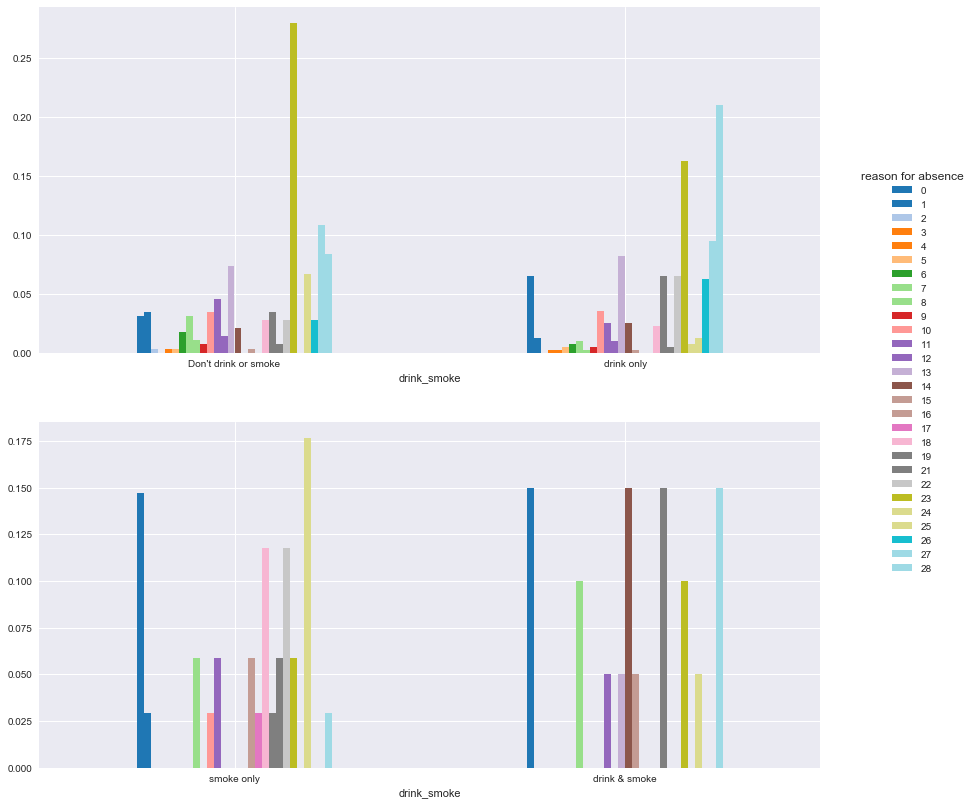

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(14)
fig.set_figheight(14)

ax = rds_ratio_group.unstack('reason_for_absence')[:2].fillna(0).plot.bar(cmap='tab20', ax=axes[0])
ax.set_xticklabels(["Don't drink or smoke", 'drink only'], rotation=0)
ax.legend_.remove()

ax = rds_ratio_group.unstack('reason_for_absence')[2:].fillna(0).plot.bar(cmap='tab20', ax=axes[1])
ax.set_xticklabels(['smoke only', 'drink & smoke'], rotation=0)
ax.legend(title='reason for absence', bbox_to_anchor=(1.04,1.75), loc="upper left")

plt.show()

Now I changed the perspective by grouping the stacks of proportion into each "drink_smoke" category, so it's easier to see which reason for absence is common among each group.

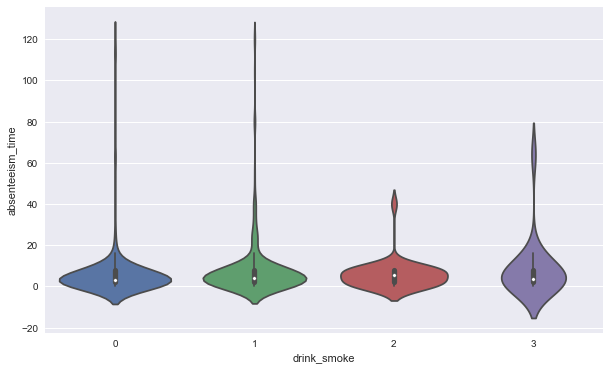

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(10)
fig.set_figheight(6)

sns.violinplot(x='drink_smoke', y='absenteeism_time', data=data, ax=axes)

plt.show()

## Work load average

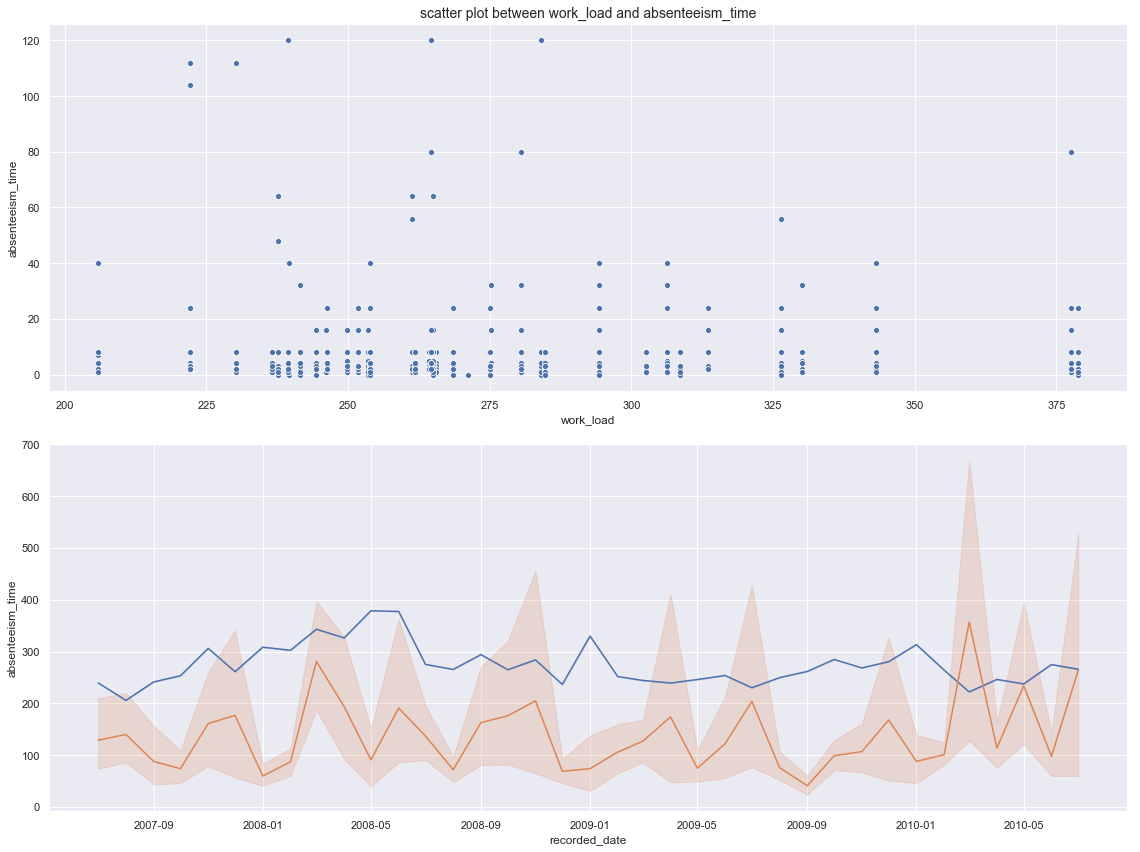

In [134]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(16)
fig.set_figheight(12)

sns.scatterplot(x='work_load', y='absenteeism_time', data=data, ax=axes[0])
axes[0].set_title('scatter plot between work_load and absenteeism_time', fontsize=14)


sns.lineplot(x='recorded_date', y='work_load', data=data, ax=axes[1])
sns.lineplot(x='recorded_date', y='absenteeism_time', estimator='sum', data=data, ax=axes[1])

plt.tight_layout()
plt.show()

From the scatter plot, we see almost no correlation between work_load_average and absenteeism time, which might because the distribution of absenteeism time is heavily skewed. Now, when we look at the line plot, we might spot some interesting changing patterns of work load average and absenteeism time. We can notice that in some months, as absenteeism time decreases, the work load average increases and vice versa. These patterns are present in several months including 2007-08, 2007-09, 2007-10, 2008-01, and so on. Even though their magnitudes of change are not fully correlated, it shows a consistent relationship between work load average and absenteeism time.

Nevertheless, it's worth keeping in mind that we don't know the nature of how work load average was measured and documented in the first place.

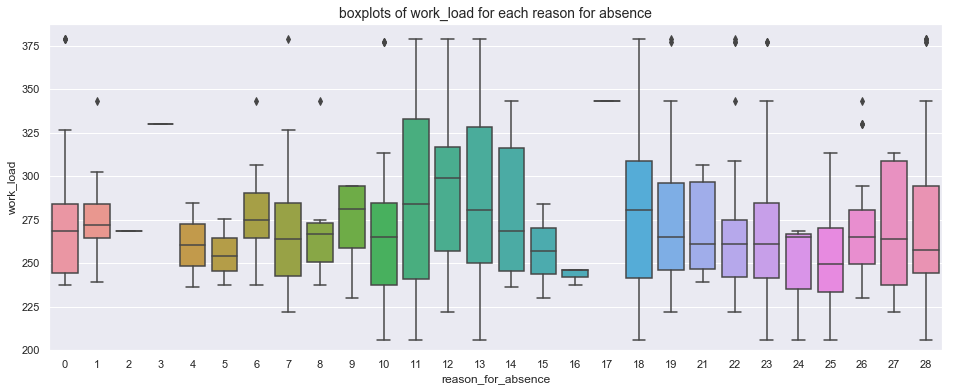

In [139]:
fig = plt.figure(figsize=(16, 6))

ax = sns.boxplot(x='reason_for_absence', y='work_load', data=data)
ax.set_ylim(200)
ax.set_title('boxplots of work_load for each reason for absence', fontsize=14)

plt.show()

There's an interesting variation in work_load_average when grouped by reason for absence.

## Distance and transportation expense

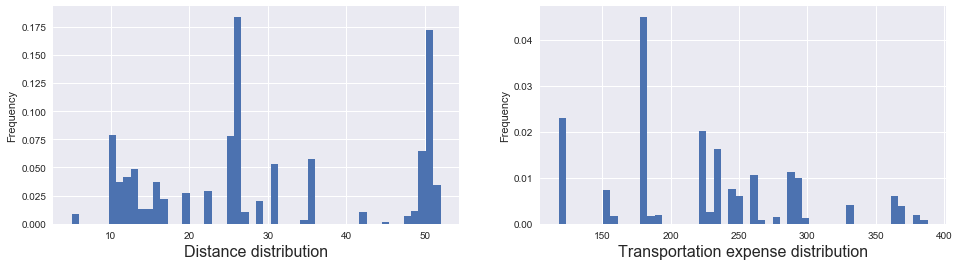

In [25]:
fig = plt.figure()
fig.set_figwidth(16)

plt.subplot(121)
ax1 = data['work_distance'].plot.hist(bins=50, density=True)
ax1.set_xlabel('Distance distribution', fontsize=16)

plt.subplot(122)
ax2 = data['transportation_expense'].plot.hist(bins=50, density=True)
ax2.set_xlabel('Transportation expense distribution', fontsize=16)

plt.show()

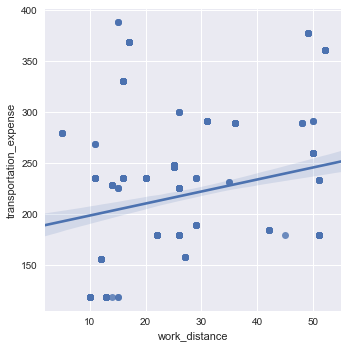

In [26]:
sns.lmplot(x='work_distance', y='transportation_expense', data=data)
plt.show()

## Dependents

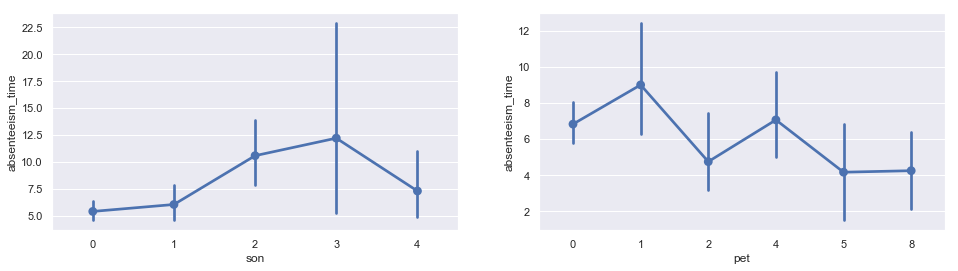

In [141]:
fig = plt.figure()
fig.set_figwidth(16)

plt.subplot(121)
sns.pointplot(x='son', y='absenteeism_time', data=data)

plt.subplot(122)
sns.pointplot(x='pet', y='absenteeism_time', data=data)

plt.show()